In [2]:
# Inputs
import math
import pandas as pd
from CoolProp.CoolProp import PropsSI

fluid = "R1234ze(E)"
Q_DH = 194.5e6
T_DH_cold_in = 35.0
T_DH_hot_out = 55.0

T_cond_sat = 60.0
T_evap_sat = 14.0

T_CW_hot_in = 25.0
T_CW_cold_out = 19.0
dT_CW = T_CW_hot_in - T_CW_cold_out

U = 2000.0
eta_list = [0.70, 0.75, 0.80, 0.85]
cp_water = 4180.0

# Conversions
Tcond = T_cond_sat + 273.15
Tevap = T_evap_sat + 273.15

pe = PropsSI("P","T",Tevap,"Q",1,fluid)
pc = PropsSI("P","T",Tcond,"Q",0,fluid)

h1 = PropsSI("H","T",Tevap,"Q",1,fluid)
s1 = PropsSI("S","T",Tevap,"Q",1,fluid)
h3 = PropsSI("H","T",Tcond,"Q",0,fluid)

h2s = PropsSI("H","P",pc,"S",s1,fluid)
T2s = PropsSI("T","P",pc,"S",s1,fluid)

rows = []

for eta in eta_list:
    h2 = h1 + (h2s - h1)/eta
    T2 = PropsSI("T","P",pc,"H",h2,fluid)
    h4 = h3
    x4 = PropsSI("Q","P",pe,"H",h4,fluid)

    q_cond = h2 - h3
    q_evap = h1 - h4
    w_comp = h2 - h1
    COP = q_cond / w_comp

    m_ref = Q_DH / q_cond
    Pel = m_ref * w_comp
    Q_evap = m_ref * q_evap

    m_DH = Q_DH / (cp_water*(T_DH_hot_out - T_DH_cold_in))
    m_CW = Q_evap / (cp_water*dT_CW)

    dT1_cnd = (Tcond - (T_DH_hot_out+273.15))
    dT2_cnd = (Tcond - (T_DH_cold_in+273.15))
    LMTD_cnd = (dT2_cnd - dT1_cnd)/math.log(dT2_cnd/dT1_cnd)

    dT1_ev = (T_CW_hot_in+273.15) - Tevap
    dT2_ev = (T_CW_cold_out+273.15) - Tevap
    LMTD_ev = (dT1_ev - dT2_ev)/math.log(dT1_ev/dT2_ev)

    A_cnd = Q_DH/(U*LMTD_cnd)
    A_ev  = Q_evap/(U*LMTD_ev)

    rows.append(dict(
        eta_is=eta,
        pe_bar=pe/1e5, pc_bar=pc/1e5,
        T1_C=T_evap_sat, h1_kJkg=h1/1000, s1_kJkgK=s1/1000,
        T2s_C=T2s-273.15, h2s_kJkg=h2s/1000,
        T2_C=T2-273.15, h2_kJkg=h2/1000,
        T3_C=T_cond_sat, h3_kJkg=h3/1000,
        h4_kJkg=h4/1000, x4=x4,
        q_cond_kJkg=q_cond/1000, q_evap_kJkg=q_evap/1000, w_comp_kJkg=w_comp/1000,
        COP=COP,
        m_ref_kgs=m_ref, Pel_MW=Pel/1e6, Q_evap_MW=Q_evap/1e6,
        m_DH_kgs=m_DH, m_CW_kgs=m_CW,
        LMTD_cnd_K=LMTD_cnd, LMTD_ev_K=LMTD_ev,
        A_cnd_m2=A_cnd, A_ev_m2=A_ev
    ))

df = pd.DataFrame(rows)
df.to_csv("keadby_hp_results.csv", index=False)

print("=== Core design inputs ===")
print(f"Fluid: {fluid}")
print(f"T_evap_sat = {T_evap_sat:.1f} °C  |  T_cond_sat = {T_cond_sat:.1f} °C")
print(f"pe = {pe/1e5:.3f} bar  |  pc = {pc/1e5:.3f} bar")
print(f"Duty to DH = {Q_DH/1e6:.1f} MW  |  DH 55/35 °C  |  CW 25→19 °C")
print(f"PHE U = {U:.0f} W/m²K\n")
print(df.to_string(index=False, float_format=lambda v: f'{v:.4f}'))
print("\nResults saved to keadby_hp_results.csv")



=== Core design inputs ===
Fluid: R1234ze(E)
T_evap_sat = 14.0 °C  |  T_cond_sat = 60.0 °C
pe = 3.524 bar  |  pc = 12.766 bar
Duty to DH = 194.5 MW  |  DH 55/35 °C  |  CW 25→19 °C
PHE U = 2000 W/m²K

 eta_is  pe_bar  pc_bar    T1_C  h1_kJkg  s1_kJkgK   T2s_C  h2s_kJkg    T2_C  h2_kJkg    T3_C  h3_kJkg  h4_kJkg     x4  q_cond_kJkg  q_evap_kJkg  w_comp_kJkg    COP  m_ref_kgs  Pel_MW  Q_evap_MW  m_DH_kgs  m_CW_kgs  LMTD_cnd_K  LMTD_ev_K  A_cnd_m2    A_ev_m2
 0.7000  3.5243 12.7657 14.0000 393.6159    1.6755 60.0000  417.6038 66.4230 427.8844 60.0000 284.7855 284.7855 0.3777     143.0989     108.8304      34.2684 4.1758  1359.1999 46.5777   147.9223 2326.5550 5898.0194     12.4267     7.6098 7825.8918  9719.2039
 0.7500  3.5243 12.7657 14.0000 393.6159    1.6755 60.0000  417.6038 64.4779 425.5998 60.0000 284.7855 284.7855 0.3777     140.8143     108.8304      31.9839 4.4027  1381.2515 44.1778   150.3222 2326.5550 5993.7085     12.4267     7.6098 7825.8918  9876.8877
 0.8000  3.5243 12.7657

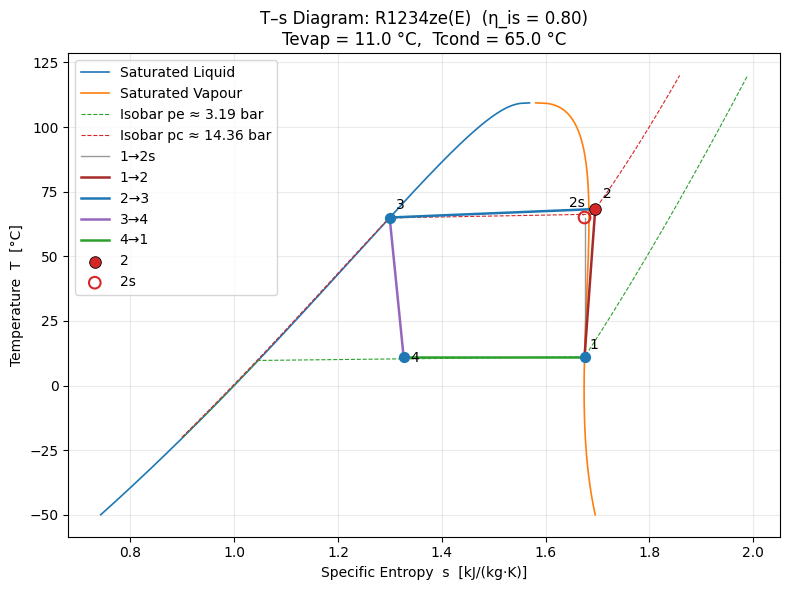

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI

# Inputs
FLUID = "R1234ze(E)"
T_EVAP_C = 11.0
T_COND_C = 65.0
ETA_ISEN = 0.80

K = lambda C: C + 273.15
C = lambda K_: K_ - 273.15
kJkg = lambda Jkg: Jkg/1000.0
kJkgK = lambda JkgK: JkgK/1000.0
bar = lambda Pa: Pa/1e5

Tevap = K(T_EVAP_C)
Tcond = K(T_COND_C)
pe = PropsSI("P","T",Tevap,"Q",1,FLUID)
pc = PropsSI("P","T",Tcond,"Q",0,FLUID)

h1 = PropsSI("H","T",Tevap,"Q",1,FLUID)
s1 = PropsSI("S","T",Tevap,"Q",1,FLUID)

h2s = PropsSI("H","P",pc,"S",s1,FLUID)
T2s = PropsSI("T","P",pc,"S",s1,FLUID)

h2 = h1 + (h2s - h1)/ETA_ISEN
T2 = PropsSI("T","P",pc,"H",h2,FLUID)
s2 = PropsSI("S","P",pc,"H",h2,FLUID)

h3 = PropsSI("H","T",Tcond,"Q",0,FLUID)
s3 = PropsSI("S","T",Tcond,"Q",0,FLUID)

h4 = h3
x4 = PropsSI("Q","P",pe,"H",h4,FLUID)
s4 = PropsSI("S","P",pe,"H",h4,FLUID)
T4 = PropsSI("T","P",pe,"H",h4,FLUID)

Tcrit = PropsSI("Tcrit", FLUID)
Tmin  = PropsSI("Tmin",  FLUID)
Ts = np.linspace(max(Tmin+1.0, K(-50)), Tcrit-0.001, 800)

s_l, T_l, s_v, T_v = [], [], [], []
for T in Ts:
    try:
        sL = PropsSI("S","T",T,"Q",0,FLUID)
        sV = PropsSI("S","T",T,"Q",1,FLUID)
        s_l.append(kJkgK(sL)); T_l.append(C(T))
        s_v.append(kJkgK(sV)); T_v.append(C(T))
    except:
        pass

def isobar_TS(P, T_low_C, T_high_C, n=100):
    Tgrid = np.linspace(K(T_low_C), K(T_high_C), n)
    sgrid = []
    for T in Tgrid:
        try:
            sgrid.append(kJkgK(PropsSI("S","T",T,"P",P,FLUID)))
        except:
            sgrid.append(np.nan)
    return C(Tgrid), np.array(sgrid)

T_low_iso, T_high_iso = -20, 120
T_pe_line, s_pe_line = isobar_TS(pe, T_low_iso, T_high_iso)
T_pc_line, s_pc_line = isobar_TS(pc, T_low_iso, T_high_iso)

plt.figure(figsize=(8,6))

plt.plot(s_l, T_l, linewidth=1.2, label="Saturated Liquid")
plt.plot(s_v, T_v, linewidth=1.2, label="Saturated Vapour")

plt.plot(s_pe_line, T_pe_line, linestyle="--", linewidth=0.8, label=f"Isobar pe ≈ {bar(pe):.2f} bar")
plt.plot(s_pc_line, T_pc_line, linestyle="--", linewidth=0.8, label=f"Isobar pc ≈ {bar(pc):.2f} bar")

S1, T1 = kJkgK(s1), C(Tevap)
S2s, T2sC = kJkgK(PropsSI("S","P",pc,"S",s1,FLUID)), C(T2s)
S2, T2C = kJkgK(s2), C(T2)
S3, T3 = kJkgK(s3), C(Tcond)
S4, T4C = kJkgK(s4), C(T4)

plt.plot([S1,S2s],[T1,T2sC], color="grey", linewidth=1.0, alpha=0.8, zorder=2, label="1→2s")
plt.plot([S1,S2],[T1,T2C], color="brown", linewidth=1.8, zorder=3, label="1→2")
plt.plot([S2,S3],[T2C,T3], color="tab:blue", linewidth=1.8, zorder=3, label="2→3")
plt.plot([S3,S4],[T3,T4C], color="tab:purple", linewidth=1.8, zorder=3, label="3→4")
plt.plot([S4,S1],[T4C,T1], color="tab:green", linewidth=1.8, zorder=3, label="4→1")

plt.scatter([S1,S3,S4],[T1,T3,T4C], s=50, color="C0", zorder=5)
plt.scatter([S2],[T2C], s=70, color="C3", edgecolor="k", linewidth=0.6, zorder=6, label="2")
plt.scatter([S2s],[T2sC], s=70, facecolors="none", edgecolors="C3", linewidths=1.5, zorder=6, label="2s")

def annotate_point(x, y, label, dx=0.015, dy=2.0):
    plt.annotate(label, xy=(x, y), xytext=(x+dx, y+dy),
                 ha="left", va="bottom",
                 arrowprops=dict(arrowstyle="-", lw=0.8, color="0.3"))

annotate_point(S1, T1, "1", dx=0.010, dy=2.0)
annotate_point(S2s, T2sC, "2s", dx=-0.030, dy=3.0)
annotate_point(S2, T2C, "2", dx=0.015, dy=3.0)
annotate_point(S3, T3, "3", dx=0.012, dy=2.0)
annotate_point(S4, T4C, "4", dx=0.012, dy=-3.0)

plt.xlabel("Specific Entropy  s  [kJ/(kg·K)]")
plt.ylabel("Temperature  T  [°C]")
plt.title(f"T–s Diagram: {FLUID}  (η_is = {ETA_ISEN:.2f})\nTevap = {T_EVAP_C:.1f} °C,  Tcond = {T_COND_C:.1f} °C")
plt.grid(True, which="both", alpha=0.25)
plt.legend(loc="best")
plt.tight_layout()
plt.show()



 Capture_%  Q_evap_MW  Q_cond_MW  P_el_MW  m_DH_20_t/s  m_DH_30_t/s  m_CW_t/s
         5      19.45     29.175    9.725        0.349        0.233     0.776
        10      38.90     58.350   19.450        0.698        0.465     1.551
        15      58.35     87.525   29.175        1.047        0.698     2.327
        20      77.80    116.700   38.900        1.396        0.931     3.102
        25      97.25    145.875   48.625        1.745        1.163     3.878
        30     116.70    175.050   58.350        2.094        1.396     4.653
        35     136.15    204.225   68.075        2.443        1.629     5.429
        40     155.60    233.400   77.800        2.792        1.861     6.204
        45     175.05    262.575   87.525        3.141        2.094     6.980
        50     194.50    291.750   97.250        3.490        2.327     7.755
        55     213.95    320.925  106.975        3.839        2.559     8.531
        60     233.40    350.100  116.700        4.188        2.

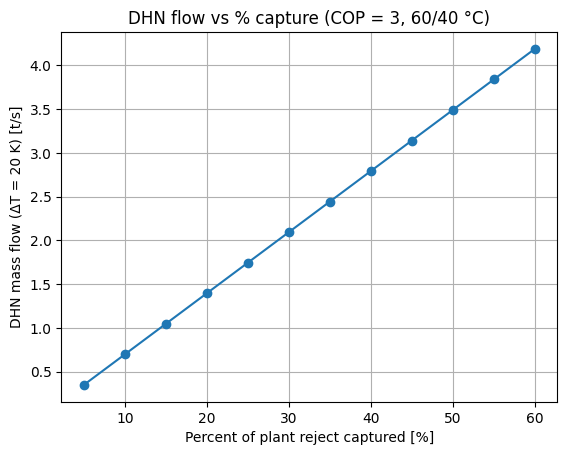

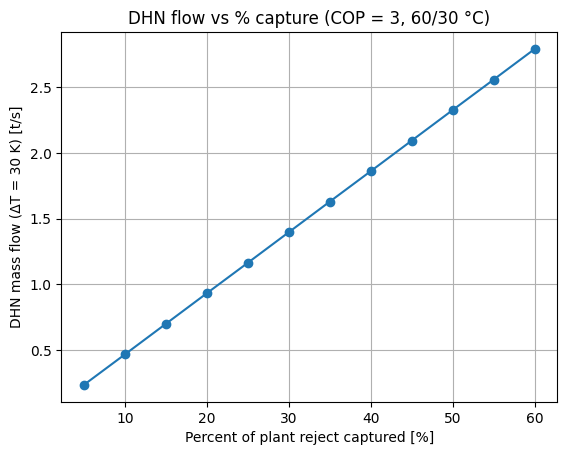

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Q_reject_total_MW = 389.0
COP_heating = 3.0
cp = 4180.0
DeltaT_DH_20 = 20.0
DeltaT_DH_30 = 30.0
DeltaT_CW = 6.0

percent_capture = np.arange(5, 61, 5)

rows = []
for p in percent_capture:
    frac = p / 100.0
    Q_evap = frac * Q_reject_total_MW
    Q_cond = Q_evap / (1 - 1 / COP_heating)
    P_el = Q_cond / COP_heating

    m_DH_20 = (Q_cond * 1e6) / (cp * DeltaT_DH_20) / 1000
    m_DH_30 = (Q_cond * 1e6) / (cp * DeltaT_DH_30) / 1000
    m_CW = (Q_evap * 1e6) / (cp * DeltaT_CW) / 1000

    rows.append([p, Q_evap, Q_cond, P_el, m_DH_20, m_DH_30, m_CW])

df = pd.DataFrame(rows, columns=[
    "Capture_%", "Q_evap_MW", "Q_cond_MW", "P_el_MW",
    "m_DH_20_t/s", "m_DH_30_t/s", "m_CW_t/s"
]).round(3)

print(df.to_string(index=False))

plt.figure()
plt.plot(df["Capture_%"], df["m_DH_20_t/s"], marker='o')
plt.xlabel("Percent of plant reject captured [%]")
plt.ylabel("DHN mass flow (ΔT = 20 K) [t/s]")
plt.title("DHN flow vs % capture (COP = 3, 60/40 °C)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(df["Capture_%"], df["m_DH_30_t/s"], marker='o')
plt.xlabel("Percent of plant reject captured [%]")
plt.ylabel("DHN mass flow (ΔT = 30 K) [t/s]")
plt.title("DHN flow vs % capture (COP = 3, 60/30 °C)")
plt.grid(True)
plt.show()




In [5]:
import math
import pandas as pd

def display_df(name: str, df: pd.DataFrame):
    try:
        from IPython.display import display
        if name:
            print(f"\n📄 {name}")
        display(df)
    except Exception:
        if name:
            print(f"\n=== {name} ===")
        print(df.to_string(index=False))

lengths_supply = {"North": 6340.0, "Central": 7000.0, "South": 8500.0}
lengths_return = lengths_supply.copy()

seg_frac = [0.2, 0.4, 0.4]

D_map = {"DN800": 0.80, "DN600": 0.60, "DN450": 0.45}

seg_dn_supply = ["DN800", "DN600", "DN450"]
seg_dn_return = ["DN450", "DN600", "DN800"]

AUTOSIZE_RETURN = True
V_MAX_RETURN = 2.5

m_dot_total = 2.96e3
rho_50C = 988.0
mu_50C = 0.000547
cp = 4180.0

flow_frac_supply = [1.0, 0.60, 0.30]
flow_frac_return = list(reversed(flow_frac_supply))

K_supply = [3.0, 3.0, 3.0]
K_return = [3.0, 3.0, 3.0]

dpp_PHE_plant = 30e3
dpp_sub_PHE   = 20e3
dpp_service   = 40e3

eps = 4.5e-5
g = 9.81

T_supply_in = 60.0
T_return_in = 40.0
T_ground = 10.0

k_ins = 0.028
k_soil = 1.5
burial_depth = 1.0

casing_D_map = {"DN800": 1.12, "DN600": 0.90, "DN450": 0.72}

eta_pump = 0.80
eta_motor = 0.97

def area(D): 
    return math.pi * D**2 / 4.0

def reynolds(rho, v, D, mu): 
    return rho * v * D / mu

def friction_factor_swamee_jain(Re, D, eps):
    if Re <= 2000:
        return 64.0 / Re if Re > 0 else 0.0
    return 0.25 / (math.log10(eps/(3.7*D) + 5.74/(Re**0.9))**2)

def head_loss_major(f, L, D, v, g=9.81): 
    return f * (L/D) * (v**2/(2*g))

def head_loss_minor(K, v, g=9.81): 
    return K * (v**2/(2*g))

def soil_resistance(D_c, depth, k_soil):
    return math.log(4.0*depth/D_c)/(2*math.pi*k_soil)

def linear_heat_loss(T_fluid, T_ground, D_steel, D_casing, k_ins, depth, k_soil):
    if T_fluid == T_ground:
        return 0.0, 0.0, 0.0, 0.0
    R_ins = math.log(D_casing/D_steel)/(2*math.pi*k_ins)
    R_soil = soil_resistance(D_casing, depth, k_soil)
    R_tot = R_ins + R_soil
    q_per_m = (T_fluid - T_ground)/R_tot
    return q_per_m, R_ins, R_soil, R_tot

DN_ORDER = ["DN450", "DN600", "DN800"]

def pick_return_dn_for_velocity(mseg, vmax=V_MAX_RETURN):
    for dn in DN_ORDER:
        D = D_map[dn]
        v = (mseg/rho_50C) / area(D)
        if v <= vmax:
            return dn, v
    dn = DN_ORDER[-1]
    D = D_map[dn]
    v = (mseg/rho_50C) / area(D)
    return dn, v

m_dot_trunk = m_dot_total / 3.0
Q_trunk = m_dot_trunk / rho_50C

results_rows = []
summary_rows = []

for trunk, Ls in lengths_supply.items():
    Lr = lengths_return[trunk]
    seg_lengths_sup = [f * Ls for f in seg_frac]
    seg_lengths_ret = [f * Lr for f in seg_frac]

    T_sup = T_supply_in
    total_heat_loss_W = 0.0
    total_head_m = 0.0

    for i in range(3):
        dn = seg_dn_supply[i]
        D  = D_map[dn]
        A  = area(D)
        frac = flow_frac_supply[i]
        mseg = m_dot_trunk * frac
        Vseg = mseg / rho_50C
        v = Vseg / A
        Re = reynolds(rho_50C, v, D, mu_50C)
        f = friction_factor_swamee_jain(Re, D, eps)
        L = seg_lengths_sup[i]
        hf = head_loss_major(f, L, D, v, g)
        hm = head_loss_minor(K_supply[i], v, g)

        D_c = casing_D_map[dn]
        qpm, R_ins, R_soil, Rtot = linear_heat_loss(T_sup, T_ground, D, D_c, k_ins, burial_depth, k_soil)
        Q_loss_seg = qpm * L
        dT_seg = Q_loss_seg / (mseg * cp) if mseg > 0 else 0.0
        T_out = T_sup - dT_seg

        total_heat_loss_W += Q_loss_seg
        total_head_m += (hf + hm)

        results_rows.append({
            "Trunk": trunk, "Leg": "Supply", "Seg": i+1, "DN": dn,
            "Length_m": L, "Flow_frac": frac, "m_dot_kgps": mseg,
            "Vel_mps": v, "Re": Re, "f": f, "hf_m": hf, "hm_m": hm,
            "T_in_C": T_sup, "T_out_C": T_out, "q_per_m_Wpm": qpm
        })

        T_sup = T_out

    T_supply_end = T_sup

    T_ret = T_return_in
    for i in range(3):
        frac = flow_frac_return[i]
        mseg = m_dot_trunk * frac

        if AUTOSIZE_RETURN:
            dn, v_guess = pick_return_dn_for_velocity(mseg, V_MAX_RETURN)
        else:
            dn = seg_dn_return[i]
            D_test = D_map[dn]
            v_guess = (mseg/rho_50C) / area(D_test)

        D  = D_map[dn]
        A  = area(D)
        Vseg = mseg / rho_50C
        v = Vseg / A
        Re = reynolds(rho_50C, v, D, mu_50C)
        f = friction_factor_swamee_jain(Re, D, eps)
        L = seg_lengths_ret[i]
        hf = head_loss_major(f, L, D, v, g)
        hm = head_loss_minor(K_return[i], v, g)

        D_c = casing_D_map[dn]
        qpm, R_ins, R_soil, Rtot = linear_heat_loss(T_ret, T_ground, D, D_c, k_ins, burial_depth, k_soil)
        Q_loss_seg = qpm * L
        dT_seg = Q_loss_seg / (mseg * cp) if mseg > 0 else 0.0
        T_out = T_ret - dT_seg

        total_heat_loss_W += Q_loss_seg
        total_head_m += (hf + hm)

        results_rows.append({
            "Trunk": trunk, "Leg": "Return", "Seg": i+1, "DN": dn,
            "Length_m": L, "Flow_frac": frac, "m_dot_kgps": mseg,
            "Vel_mps": v, "Re": Re, "f": f, "hf_m": hf, "hm_m": hm,
            "T_in_C": T_ret, "T_out_C": T_out, "q_per_m_Wpm": qpm
        })

        T_ret = T_out

    dpp_components = dpp_PHE_plant + dpp_sub_PHE + dpp_service
    H_components_m = dpp_components / (rho_50C * g)
    H_total_trunk_m = total_head_m + H_components_m

    V_trunk_in = m_dot_trunk / rho_50C
    P_shaft_trunk = rho_50C * g * V_trunk_in * H_total_trunk_m / eta_pump
    P_elec_trunk = P_shaft_trunk / eta_motor

    summary_rows.append({
        "Trunk": trunk,
        "Supply_length_km": Ls / 1000.0,
        "Return_length_km": Lr / 1000.0,
        "Total_linear_heat_loss_kW": total_heat_loss_W / 1e3,
        "Supply_T_end_C": T_supply_end,
        "Loop_head_m (incl.components)": H_total_trunk_m,
        "Per-trunk_pump_elec_kW": P_elec_trunk / 1e3
    })

df_segments = pd.DataFrame(results_rows)
df_summary  = pd.DataFrame(summary_rows)

H_governing = df_summary["Loop_head_m (incl.components)"].max()
V_total = m_dot_total / rho_50C
P_shaft_common = rho_50C * g * V_total * H_governing / eta_pump
P_elec_common  = P_shaft_common / eta_motor

system_summary = pd.DataFrame([{
    "Governing_head_m": H_governing,
    "Total_flow_m3ps": V_total,
    "Common_pump_elec_MW": P_elec_common / 1e6,
    "Sum_of_per_trunk_pumps_MW": df_summary["Per-trunk_pump_elec_kW"].sum() / 1e6
}])

def tidy(df: pd.DataFrame) -> pd.DataFrame:
    return df.copy().round({
        "Length_m": 0, "Flow_frac": 2, "m_dot_kgps": 1, "Vel_mps": 2, "Re": 0, "f": 4,
        "hf_m": 2, "hm_m": 2, "T_in_C": 2, "T_out_C": 2, "q_per_m_Wpm": 0,
        "Supply_length_km": 2, "Return_length_km": 2, "Total_linear_heat_loss_kW": 0,
        "Supply_T_end_C": 2, "Loop_head_m (incl.components)": 1,
        "Per-trunk_pump_elec_kW": 0,
        "Governing_head_m": 1, "Total_flow_m3ps": 3,
        "Common_pump_elec_MW": 3, "Sum_of_per_trunk_pumps_MW": 3
    })

df_segments_tidy = tidy(df_segments)
df_summary_tidy  = tidy(df_summary)
system_summary_tidy = tidy(system_summary)

display_df("DHN Segment Results", df_segments_tidy)
display_df("DHN Trunk Summary", df_summary_tidy)
display_df("DHN System Pump Summary", system_summary_tidy)

df_segments_tidy.to_csv("dhn_segment_results.csv", index=False)
df_summary_tidy.to_csv("dhn_trunk_summary.csv", index=False)
system_summary_tidy.to_csv("dhn_system_pump_summary.csv", index=False)

print("\nSaved files:")
print(" - dhn_segment_results.csv")
print(" - dhn_trunk_summary.csv")
print(" - dhn_system_pump_summary.csv")




📄 DHN Segment Results


,Trunk,Leg,Seg,DN,Length_m,Flow_frac,m_dot_kgps,Vel_mps,Re,f,hf_m,hm_m,T_in_C,T_out_C,q_per_m_Wpm
0,North,Supply,1,DN800,1268.0,1.0,986.7,1.99,2870802.0,0.0117,3.74,0.60,60.00,59.99,24.0
1,North,Supply,2,DN600,2536.0,0.6,592.0,2.12,2296642.0,0.0123,11.90,0.69,59.99,59.97,20.0
2,North,Supply,3,DN450,2536.0,0.3,296.0,1.88,1531094.0,0.0131,13.34,0.54,59.97,59.94,18.0
3,North,Return,1,DN450,1268.0,0.3,296.0,1.88,1531094.0,0.0131,6.67,0.54,40.00,39.99,11.0
4,North,Return,2,DN600,2536.0,0.6,592.0,2.12,2296642.0,0.0123,11.90,0.69,39.99,39.98,12.0
5,North,Return,3,DN800,2536.0,1.0,986.7,1.99,2870802.0,0.0117,7.47,0.60,39.98,39.97,15.0
6,Central,Supply,1,DN800,1400.0,1.0,986.7,1.99,2870802.0,0.0117,4.13,0.60,60.00,59.99,24.0
7,Central,Supply,2,DN600,2800.0,0.6,592.0,2.12,2296642.0,0.0123,13.14,0.69,59.99,59.97,20.0
8,Central,Supply,3,DN450,2800.0,0.3,296.0,1.88,1531094.0,0.0131,14.73,0.54,59.97,59.93,18.0
9,Central,Return,1,DN450,1400.0,0.3,296.0,1.88,1531094.0,0.0131,7.36,0.54,40.00,39.99,11.0



📄 DHN Trunk Summary


,Trunk,Supply_length_km,Return_length_km,Total_linear_heat_loss_kW,Supply_T_end_C,Loop_head_m (incl.components),Per-trunk_pump_elec_kW
0,North,6.34,6.34,208.0,59.94,68.0,848.0
1,Central,7.00,7.00,230.0,59.93,73.7,919.0
2,South,8.50,8.50,279.0,59.91,86.7,1082.0



📄 DHN System Pump Summary


,Governing_head_m,Total_flow_m3ps,Common_pump_elec_MW,Sum_of_per_trunk_pumps_MW
0,86.7,2.996,3.245,0.003



Saved files:
 - dhn_segment_results.csv
 - dhn_trunk_summary.csv
 - dhn_system_pump_summary.csv


In [1]:
# Single-case LCOH calculation for Scunthorpe DH (central assumptions)

# --- Core inputs ---
Q_cond_MW = 249.1          # MW_th delivered
Q_evap_MW = 166.1          # MW_th evaporator duty
Pel_comp_MW = 83.0         # MW_e compressor
Pel_pumps_MW = 3.3         # MW_e DH pumps
H = 3000                   # full-load hours per year
elec_price = 80.0          # £/MWh_e
r = 0.05                   # real discount rate
n = 30                     # project life (years)

# --- Energy ---
E_heat_MWh = Q_cond_MW * H
E_el_MWh = (Pel_comp_MW + Pel_pumps_MW) * H

# --- Capital Recovery Factor ---
def crf(r, n):
    return r * (1 + r)**n / ((1 + r)**n - 1)

CRF = crf(r, n)

# --- Pipe geometry (three trunks: north, central, south) ---
north = {'DN800': 1268 + 2536, 'DN600': 2536 + 2536, 'DN450': 2536 + 1268}
central = {'DN800': 1400 + 2800, 'DN600': 2800 + 2800, 'DN450': 2800 + 1400}
south = {'DN800': 1700 + 3400, 'DN600': 3400 + 3400, 'DN450': 3400 + 1700}

pipe_lengths = {}
for trunk in (north, central, south):
    for dn, L in trunk.items():
        pipe_lengths[dn] = pipe_lengths.get(dn, 0) + L

unit_cost_per_m = {'DN450': 1950.0, 'DN600': 1950.0, 'DN800': 2900.0}
trunk_pipe_cost_total = sum(pipe_lengths[dn] * unit_cost_per_m[dn] for dn in pipe_lengths)

# Trunks taken as 30% of total pipework cost
total_pipework_cost = trunk_pipe_cost_total / 0.30

# --- Plant CAPEX ---
hp_unit_cost_per_kWth = 650.0
hp_capex = Q_cond_MW * 1000 * hp_unit_cost_per_kWth

phe_unit_cost_cond = 200.0
phe_unit_cost_evap = 150.0
phe_capex = (Q_cond_MW * 1000 * phe_unit_cost_cond) + (Q_evap_MW * 1000 * phe_unit_cost_evap)

elec_works_unit_per_MWe = 300000.0
elec_works_capex = (Pel_comp_MW + Pel_pumps_MW) * elec_works_unit_per_MWe

num_substations = 180
substation_unit_cost = 85000.0
substations_capex = num_substations * substation_unit_cost

buildings_civils_pct = 0.10
buildings_civils_capex = buildings_civils_pct * (hp_capex + phe_capex + elec_works_capex)

# Controls + contingency
controls_pct = 0.03
contingency_pct = 0.15

subtotal_before_controls = (
    total_pipework_cost
    + hp_capex
    + phe_capex
    + elec_works_capex
    + substations_capex
    + buildings_civils_capex
)

controls_capex = controls_pct * subtotal_before_controls
subtotal_excl_contingency = subtotal_before_controls + controls_capex
contingency_capex = contingency_pct * subtotal_excl_contingency

total_capex = subtotal_excl_contingency + contingency_capex

# --- OPEX ---
FOM_per_kWth = 15.0     # £/kW_th/a
VOM_per_kWth = 9.0      # £/kW_th/a

FOM_annual = FOM_per_kWth * Q_cond_MW * 1000
VOM_annual = VOM_per_kWth * Q_cond_MW * 1000

replacement_pct = 0.01
replacement_annual = replacement_pct * (hp_capex + phe_capex)

elec_opex = elec_price * E_el_MWh
opex_total = elec_opex + FOM_annual + VOM_annual + replacement_annual

# --- LCOH ---
annualised_capex = CRF * total_capex
LCOH = (annualised_capex + opex_total) / E_heat_MWh  # £/MWh_th

print(f"Total CAPEX: £{total_capex:,.0f}")
print(f"Annualised CAPEX: £{annualised_capex:,.0f}/yr")
print(f"Total OPEX: £{opex_total:,.0f}/yr")
print(f"LCOH (central case, plant boundary): £{LCOH:.2f}/MWh_th")


Total CAPEX: £745,654,595
Annualised CAPEX: £48,505,901/yr
Total OPEX: £29,056,900/yr
LCOH (central case, plant boundary): £103.79/MWh_th
